In [1]:
import sys as _sys
import warnings as _wrn
import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_wrn.filterwarnings('always')
_plt.style.use('ggplot')

In [2]:
import eQTLseq as _assoc

Fitting gene 12612 of 12613
540 genes did not converge
/home/dimitris/VENVS/py34-scipy/lib/python3.4/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/dimitris/VENVS/py34-scipy/lib/python3.4/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


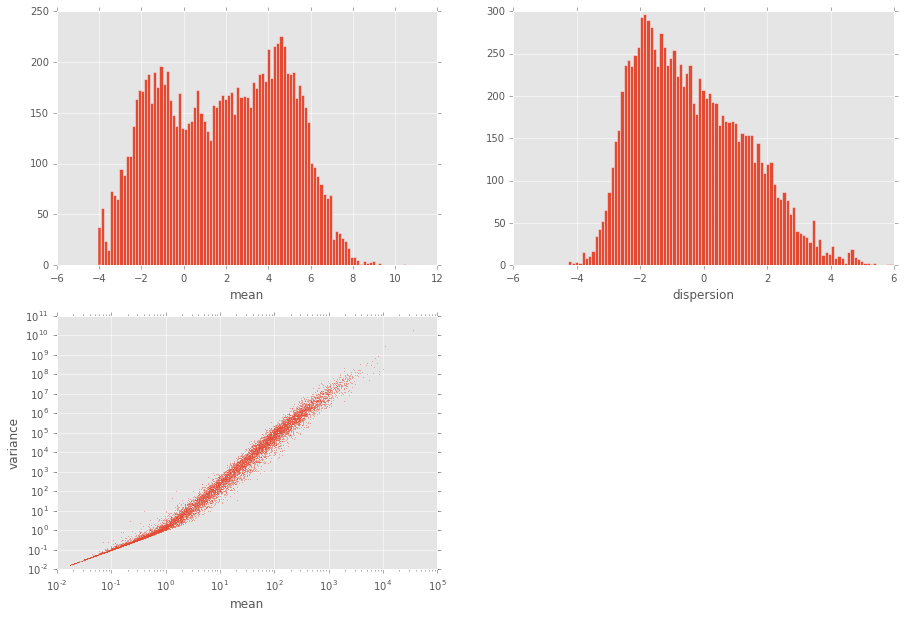

In [3]:
def fcn(fname):
    counts_CEU = _pnd.read_table(fname, index_col=0).values
    counts_CEU = counts_CEU[counts_CEU.sum(1)>0, :]  # remove zero-sum rows
    fit = _assoc.fit_nbinom_model(counts_CEU)
    print('{} genes did not converge'.format((~fit['converged']).sum()), file=_sys.stderr)
    idxs = (fit['converged']) & (_nmp.log(fit['phi']) > -10)
    pars = {'mu': fit['mu'][idxs], 'phi': fit['phi'][idxs]}
    
    return pars

##
pars = fcn('data/montpick_count_table_CEU.txt')

_plt.figure(figsize=(15,10))
_plt.subplot(2,2,1); _plt.hist(_nmp.log(pars['mu']), 100); _plt.xlabel('mean')
_plt.subplot(2,2,2); _plt.hist(_nmp.log(pars['phi']), 100); _plt.xlabel('dispersion');
_plt.subplot(2,2,3); _plt.loglog(pars['mu'], pars['mu'] + pars['mu']**2 / pars['phi'], '.', markersize=0.5); _plt.xlabel('mean'); _plt.ylabel('variance');

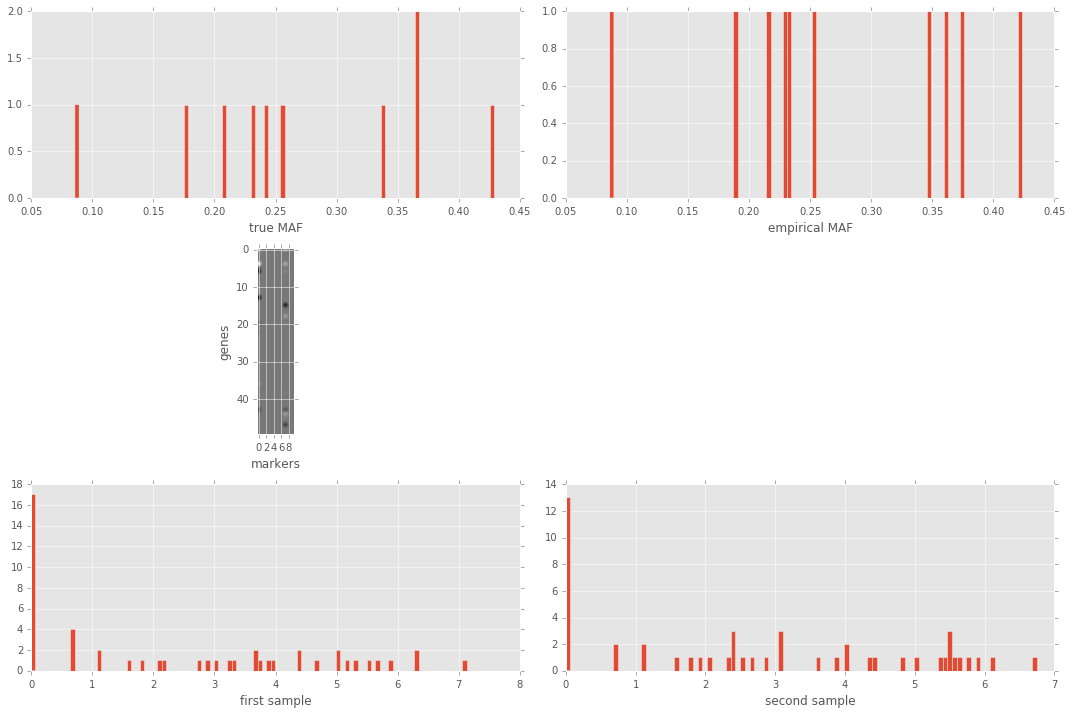

In [133]:
def fcn(n_samples, n_markers, n_markers_causal, n_genes, n_genes_affected, MAF_range):
    data_geno = _assoc.simulate_genotypes(n_samples, n_markers, MAF_range)
    data_pheno = _assoc.simulate_eQTLs_nbinom(data_geno['G'], pars['mu'], pars['phi'], n_markers_causal=n_markers_causal, n_genes=n_genes, n_genes_affected=n_genes_affected, h2=0.5)

    _plt.figure(figsize = (15,10));
    _plt.subplot(3,2,1); _plt.hist(data_geno['MAF'], 100); _plt.xlabel('true MAF')
    _plt.subplot(3,2,2); _plt.hist(data_geno['G'].sum(0) / (2 * n_samples), 100); _plt.xlabel('empirical MAF')
    _plt.subplot(3,2,3); _plt.imshow(data_pheno['beta'], cmap=_plt.cm.gray); _plt.xlabel('markers'); _plt.ylabel('genes')
#     _plt.subplot(3,2,4); _plt.loglog(data_pheno['mu'], data_pheno['mu'] + data_pheno['mu']**2 / data_pheno['phi'], '.'); _plt.xlabel('mean'); _plt.ylabel('variance');
    _plt.subplot(3,2,5); _plt.hist(_nmp.log(data_pheno['Z'][0,:]+1), 100); _plt.xlabel('first sample');
    _plt.subplot(3,2,6); _plt.hist(_nmp.log(data_pheno['Z'][1,:]+1), 100); _plt.xlabel('second sample');
    _plt.tight_layout()
    
    return data_geno, data_pheno

##
data_geno, data_pheno = fcn(n_samples = 1000,
                            n_markers = 10, n_markers_causal = 2,
                            n_genes = 50, n_genes_affected = 10,
                            MAF_range = [0.05, 0.5])

In [145]:
loglik, estim = _assoc.run(data_pheno['Z'], data_geno['G'], n_iters = 1000,
                           mdl='Poisson', 
                           trans='Log',
                           norm_factors=None)

Preparing data...
Iteration 1000 of 1000
Done!


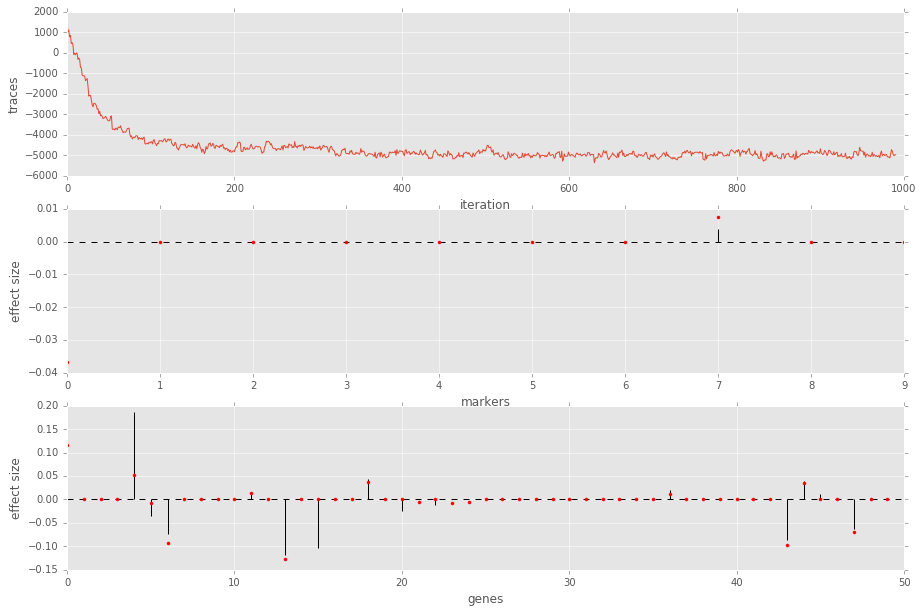

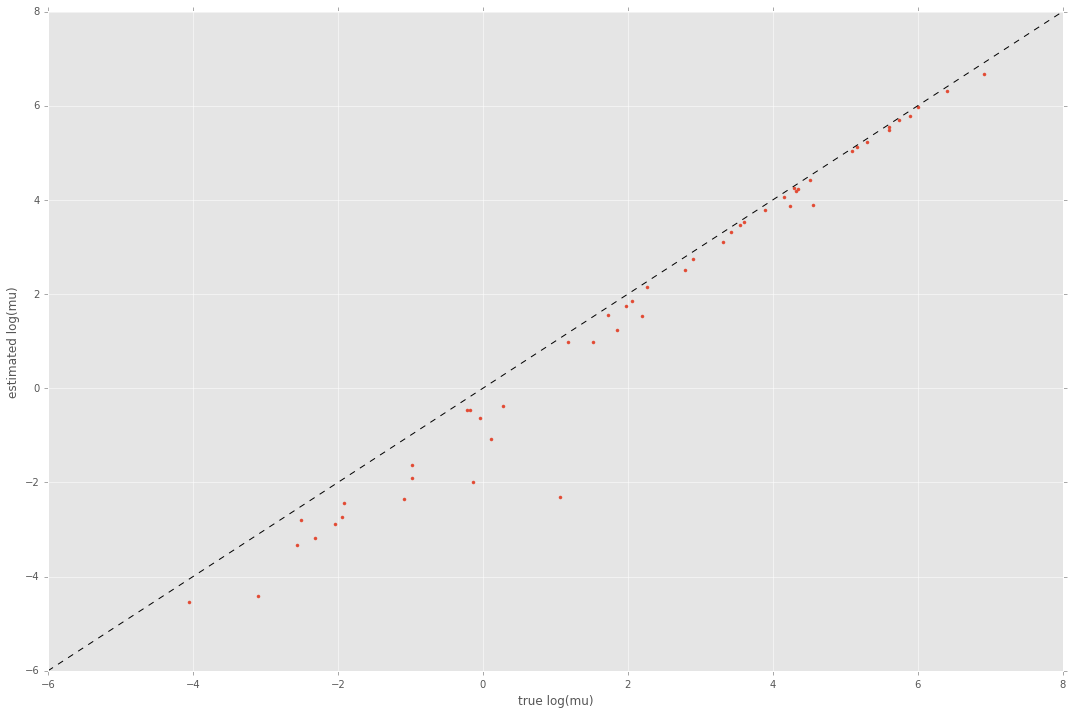

In [146]:
_plt.figure(figsize = (15,10));
_plt.subplot(3,1,1); _plt.plot(loglik[10:]); _plt.xlabel('iteration'); _plt.ylabel('traces')

_plt.subplot(3,1,2); 
_plt.vlines(range(data_pheno['beta'].shape[1]), 0, _nmp.mean(data_pheno['beta'], 0)); 
_plt.axhline(linestyle='--', color='k');
_plt.plot(_nmp.mean(estim['beta'], 0), 'r.'); _plt.xlabel('markers'); _plt.ylabel('effect size')

_plt.subplot(3,1,3); 
_plt.vlines(range(data_pheno['beta'].shape[0]), 0, _nmp.mean(data_pheno['beta'], 1)); 
_plt.axhline(linestyle='--', color='k');
_plt.plot(_nmp.mean(estim['beta'], 1), 'r.'); _plt.xlabel('genes'); _plt.ylabel('effect size')

if 'phi' in estim:
    _plt.figure(figsize = (15,10))
    _plt.plot(_nmp.log(data_pheno['phi']), _nmp.log(estim['phi']), '.'); _plt.ylim(_plt.xlim()); 
    _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
    _plt.xlabel('true log(phi)'); _plt.ylabel('estimated log(phi)')

if 'mu' in estim:
    _plt.figure(figsize = (15,10))
    _plt.plot(_nmp.log(data_pheno['mu']), _nmp.log(estim['mu']), '.'); _plt.ylim(_plt.xlim()); 
    _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
    _plt.xlabel('true log(mu)'); _plt.ylabel('estimated log(mu)')

_plt.tight_layout()

In [47]:
estim['tau']

array([ 1.00524978,  1.00478828,  1.01256546,  1.01175778,  1.04393479,
        1.01354349,  1.00143922,  1.01592969,  1.05573892,  1.00114766,
        0.98207375,  0.95676029,  0.97481645,  1.01119332,  1.05134146,
        1.00582282,  0.98630504,  1.07348248,  1.01606317,  1.10719862,
        1.0030333 ,  1.02716667,  1.00452292,  1.11847649,  1.07408917,
        1.00697658,  1.01352482,  1.09982491,  1.08700261,  1.11140709,
        1.00535961,  1.00508451,  1.09327937,  1.02106802,  1.08602922,
        1.01434606,  1.08555318,  1.08879724,  1.00496607,  1.00748471,
        1.00246571,  1.05697414,  1.03569284,  1.00401894,  0.97326845,
        1.01679333,  0.91806021,  1.02518949,  1.06143611,  1.0283269 ])